* Best score:  0.962

Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector

# Misc
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)


### Load and Preview the Train data

In [2]:
### Load and Read data
train_data = pd.read_csv('train.csv')

### Quick shape and preview
print('Training data shape:',train_data.shape)
train_data.head()

Training data shape: (80000, 18)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


###  Data Exploration

Checking Missing Values obj_ID           0
alpha            0
delta            0
u              362
g                0
r                0
i                0
z                0
run_ID           0
rerun_ID         0
cam_col          0
field_ID         0
spec_obj_ID      0
class            0
redshift         0
plate            0
MJD              0
fiber_ID         0
dtype: int64

Missing Values After Filling:
obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64
Target class Distribution
class
GALAXY    47585
STAR      17251
QSO       15164
Name: count, dtype: int64
Data Types:
obj_ID         float64
alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              

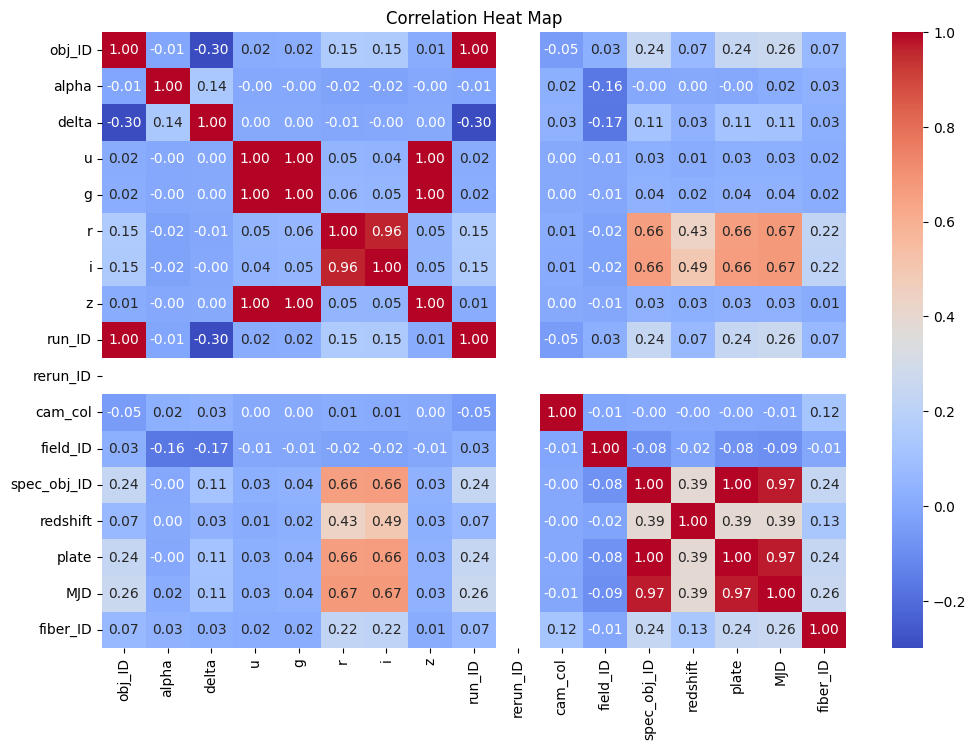

In [3]:
### Checking for the missing values
print('Checking Missing Values',train_data.isnull().sum())

# Fill missing values in 'u' column with median
train_data['u'].fillna(train_data['u'].median(), inplace=True)

# Recheck missing values after filling
print("\nMissing Values After Filling:")
print(train_data.isnull().sum())

### Checking for unique values in class
print('Target class Distribution')
print(train_data['class'].value_counts())

print('Data Types:')
print(train_data.dtypes)

### Correlation Matrix for numeric columns
plt.figure(figsize=(12,8))
sns.heatmap(train_data.select_dtypes(include=[np.number]).corr(), annot=True, fmt='.2f', cmap='coolwarm')

plt.title('Correlation Heat Map')
plt.show()

It appears that there are 362 missing values in the columns u_minus_ and 'u-g' in the data and so imputed with medians

This image is a correlation heat map visualizing the relationships between different astronomical data variables using a color scale to indicate the strength and direction of the correlations.

### Data Visualization

### 1. Class Distribution

* We begin by visualizing the distribution of the target variable (class), which includes three types of celestial objects: GALAXY, STAR, and QSO. Understanding class balance is crucial for choosing evaluation metrics. Since the dataset is imbalanced, we use the macro F1-score during model evaluation.

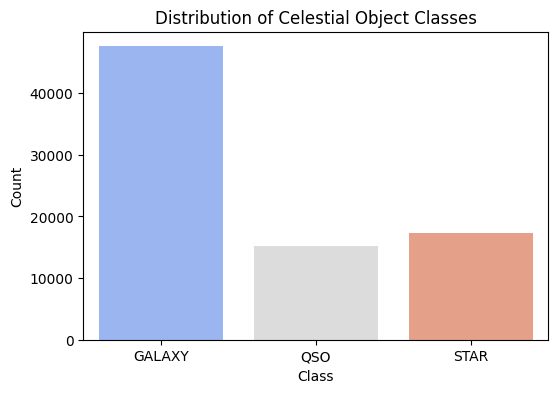

In [4]:
# Make a copy to avoid modifying original data
eda_data = train_data.copy()

# Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=eda_data, x='class', palette='coolwarm')
plt.title("Distribution of Celestial Object Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


This shows us how many examples belong to each class (GALAXY, STAR, QSO). If the classes are imbalanced, we might use techniques like F1-score or stratified splitting.

* To investigate how redshift varies across different object classes, we used a boxplot grouped by class.

This plot clearly shows that redshift is a highly discriminative feature. Since each class tends to cluster around a different redshift range, this feature is valuable for classification and should be preserved during feature selection or dimensionality reduction.

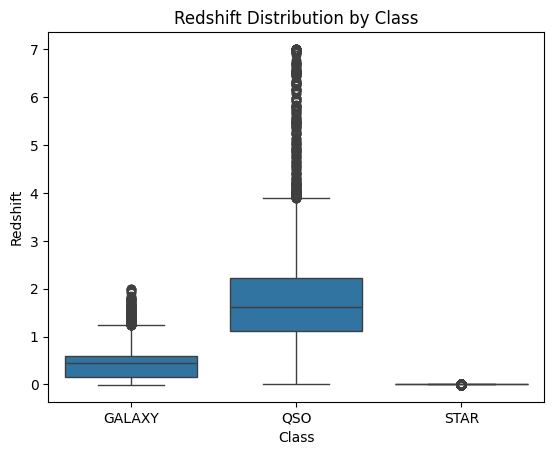

In [5]:
sns.boxplot(data=train_data, x='class', y='redshift')
plt.title("Redshift Distribution by Class")
plt.xlabel("Class")
plt.ylabel("Redshift")
plt.show()


u-g-r Color Index Distribution
We used the below to understand differences in brightness/magnitude between filters.

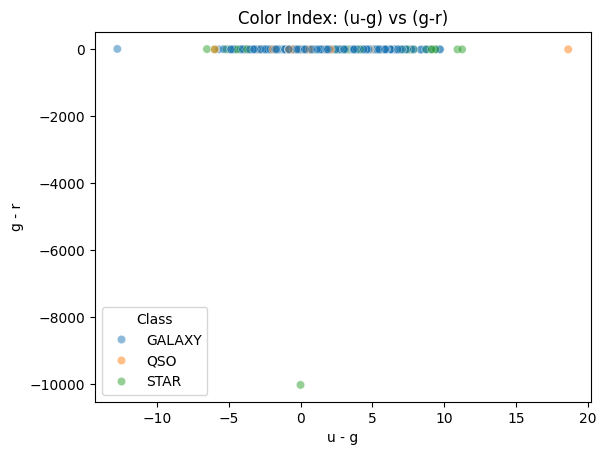

In [6]:
train_data['u_minus_g'] = train_data['u'] - train_data['g']
train_data['g_minus_r'] = train_data['g'] - train_data['r']

sns.scatterplot(data=train_data, x='u_minus_g', y='g_minus_r', hue='class', alpha=0.5)
plt.title("Color Index: (u-g) vs (g-r)")
plt.xlabel("u - g")
plt.ylabel("g - r")
plt.legend(title="Class")
plt.show()


Color indexes (differences in magnitude between bands) to classify celestial objects. This plot shows class separation using spectral features.

#### Redshift vs Color Features
The top image illustrates the relationship between redshift and (u-g) color for astronomical objects classified as GALAXY, QSO, or STAR.

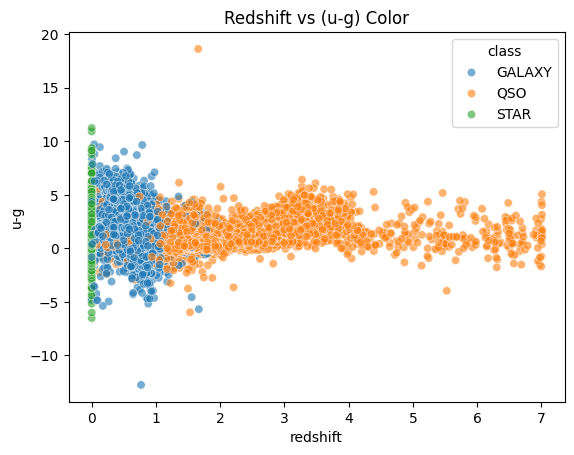

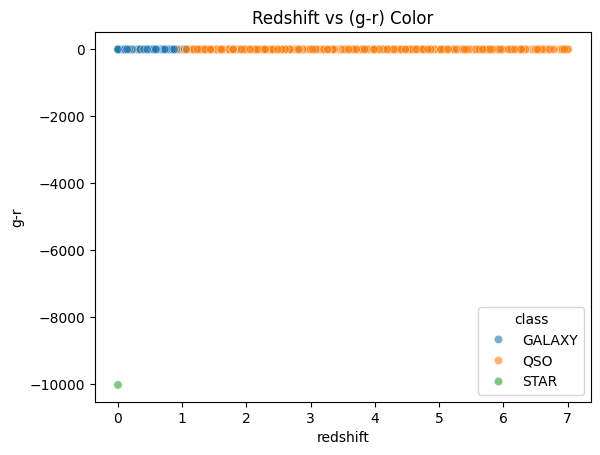

In [7]:
train_data['u-g'] = train_data['u'] - train_data['g']
train_data['g-r'] = train_data['g'] - train_data['r']

sns.scatterplot(data=train_data, x='redshift', y='u-g', hue='class', alpha=0.6)
plt.title('Redshift vs (u-g) Color')
plt.show()

sns.scatterplot(data=train_data, x='redshift', y='g-r', hue='class', alpha=0.6)
plt.title('Redshift vs (g-r) Color')
plt.show()


### Data Cleaning and Preprocessing

In [8]:
### copy the data
df=train_data.copy()

### Drop unnecessary ID columns
df.drop(columns=['obj_ID', 'spec_obj_ID', 'run_ID', 'field_ID', 'fiber_ID', 'plate', 'MJD'], inplace=True)

### Fill missing values with median
df['u']=df['u'].fillna(df['u'].median())

### Label encode the target variable
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
df['class'] = le.fit_transform(df['class'])

### Print the encoded lable for clarity
print('Encoded class labels: ')
for i,label in enumerate(le.classes_):
    print(f'{label} -> {i}')

# Check
df.head()

Encoded class labels: 
GALAXY -> 0
QSO -> 1
STAR -> 2


,alpha,delta,u,g,r,i,z,rerun_ID,cam_col,class,redshift,u_minus_g,g_minus_r,u-g,g-r
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,301,2,0,0.634794,1.60352,1.88029,1.60352,1.88029
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,301,5,0,0.779136,1.94571,0.24744,1.94571,0.24744
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,301,2,0,0.644195,2.59918,2.05413,2.59918,2.05413
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,301,3,0,0.932346,-1.63974,2.16494,-1.63974,2.16494
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,301,3,0,0.116123,1.85690,1.08281,1.85690,1.08281


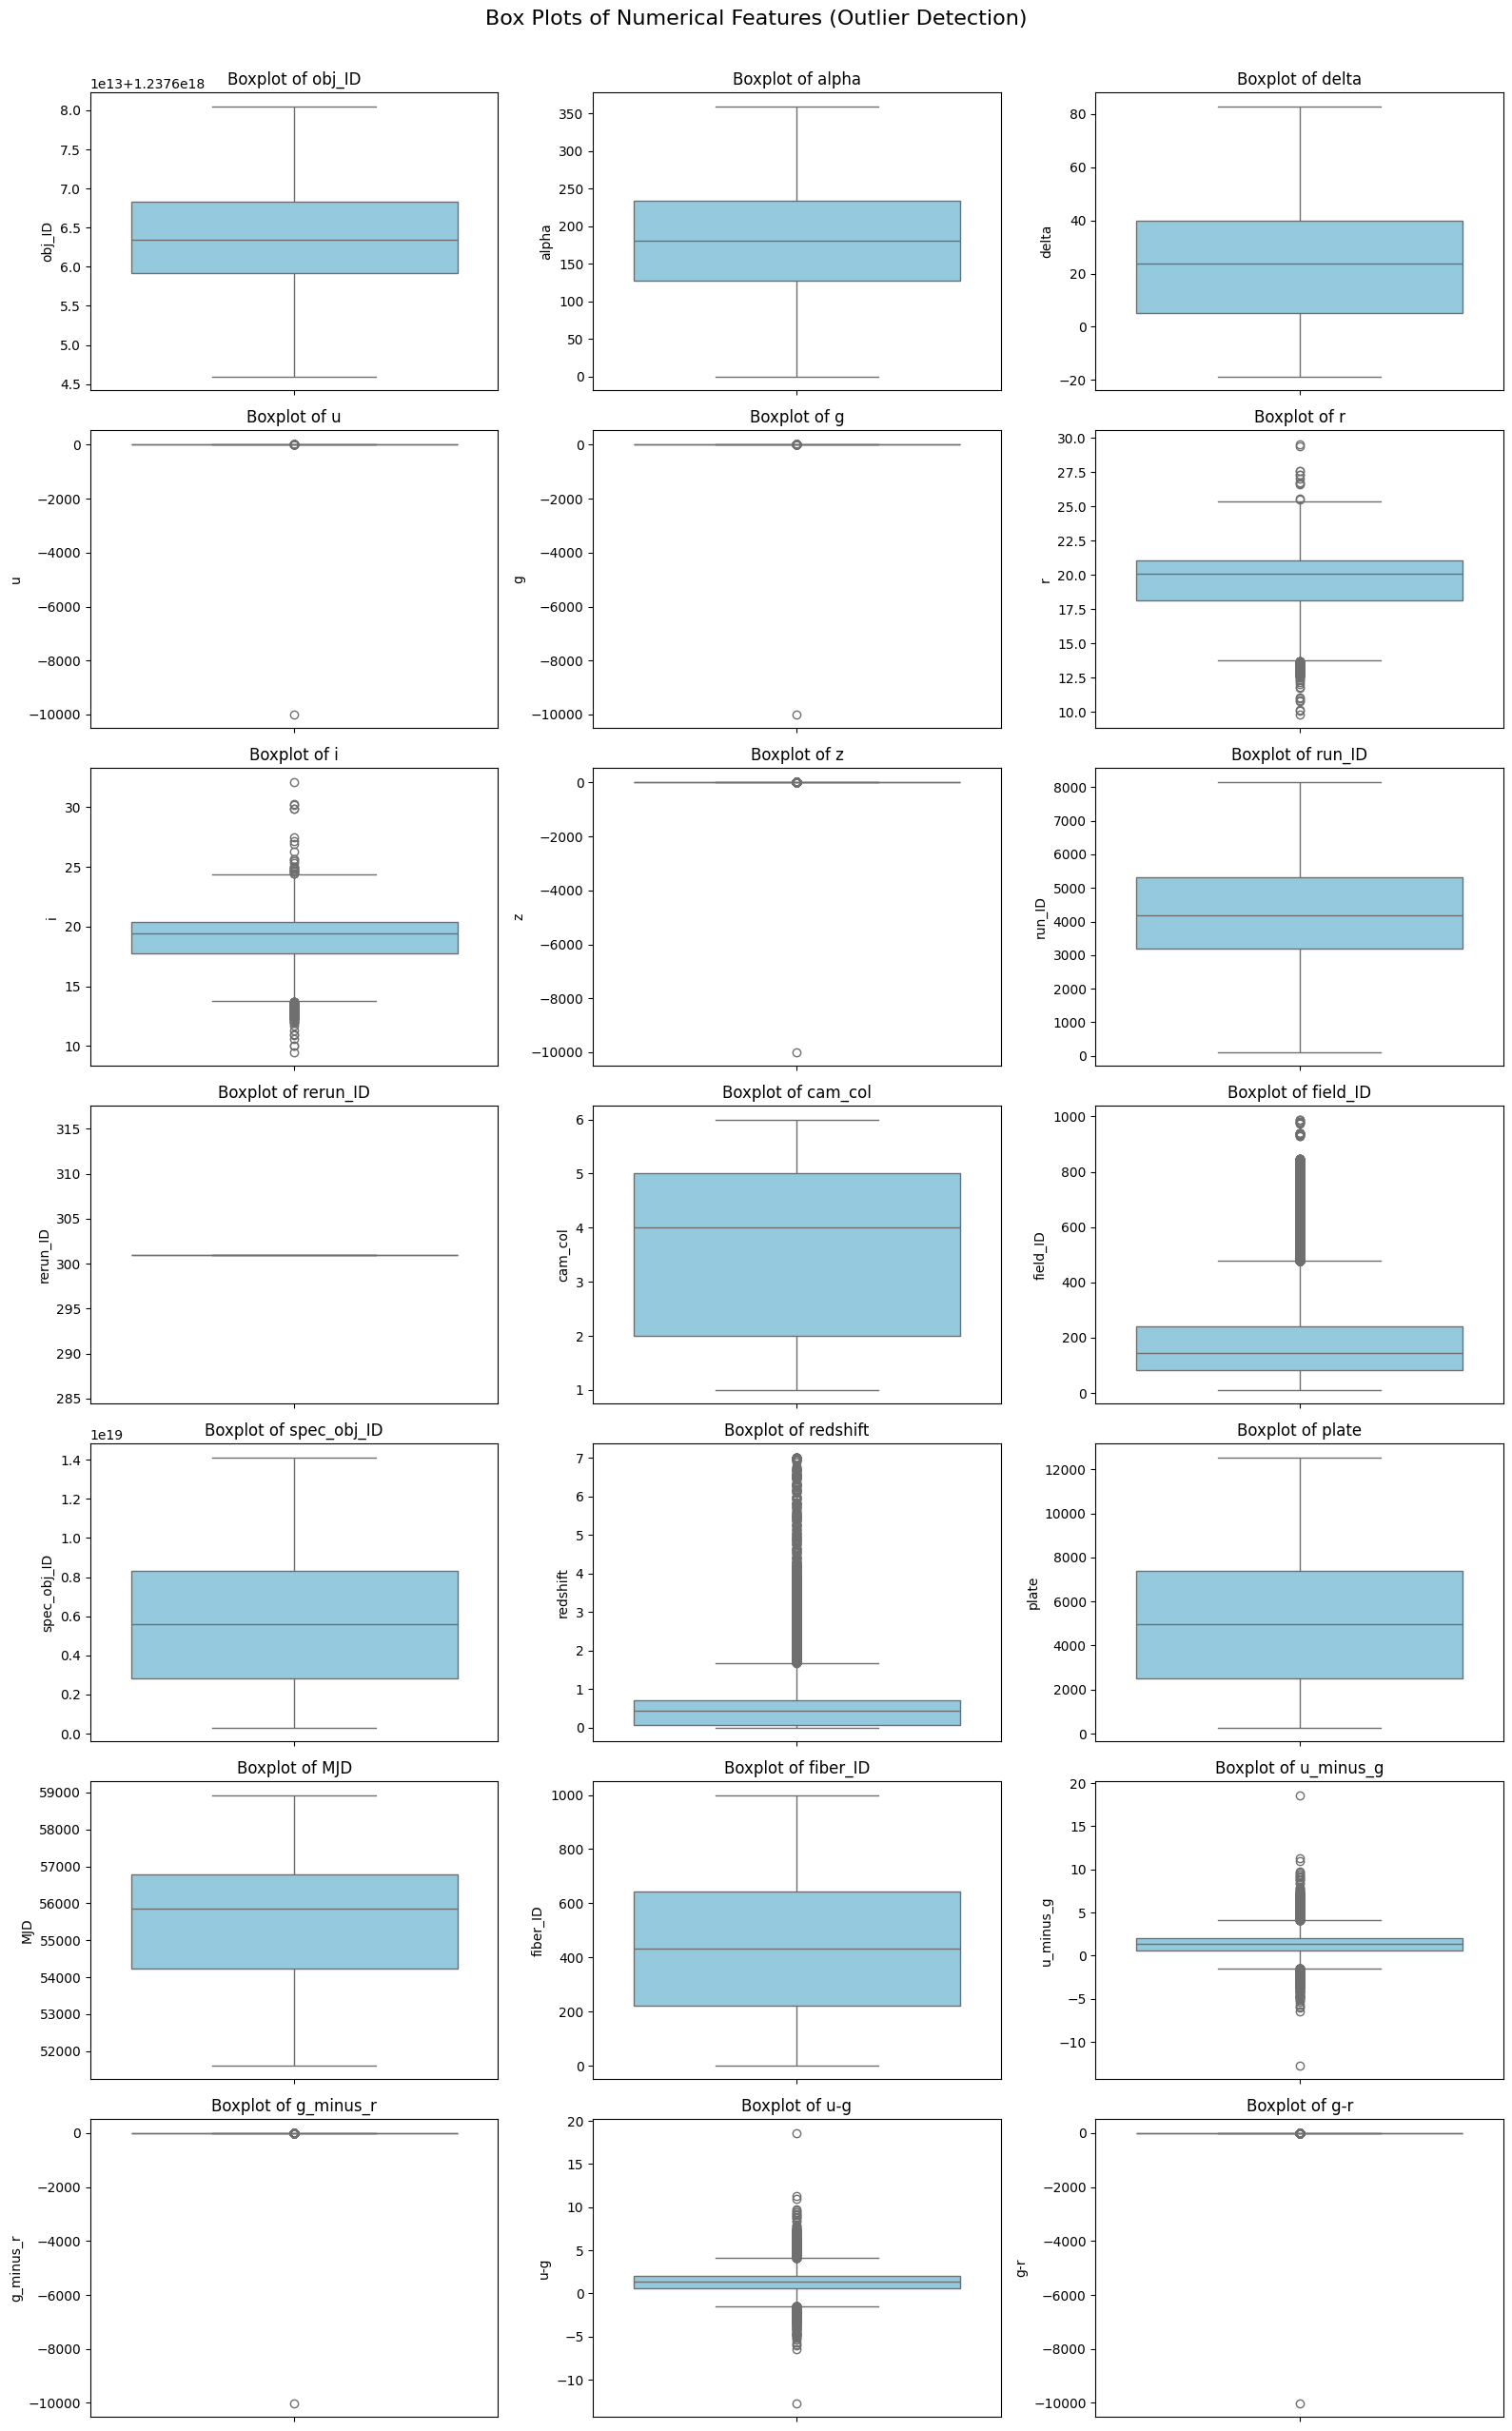

In [9]:
# Select numeric features, excluding the target
numeric_cols = train_data.select_dtypes(include=['float64', 'int64']).columns.drop('class', errors='ignore')

# Plot box plots
plt.figure(figsize=(16, 25))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot((len(numeric_cols) + 2) // 3, 3, i)
    sns.boxplot(data=train_data, y=col, color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.suptitle('Box Plots of Numerical Features (Outlier Detection)', fontsize=16, y=1.02)
plt.show()


The above image displays a collection of box plots arranged in a grid, titled "Box Plots of Numerical Features (Outlier Detection)". Each individual box plot visualizes the distribution, including median, quartiles, and potential outliers (indicated by points outside the whiskers), for a different numerical feature such as 'u', 'g', 'r', 'redshift', 'alpha', 'delta', and various ID fields, likely related to astronomical data.

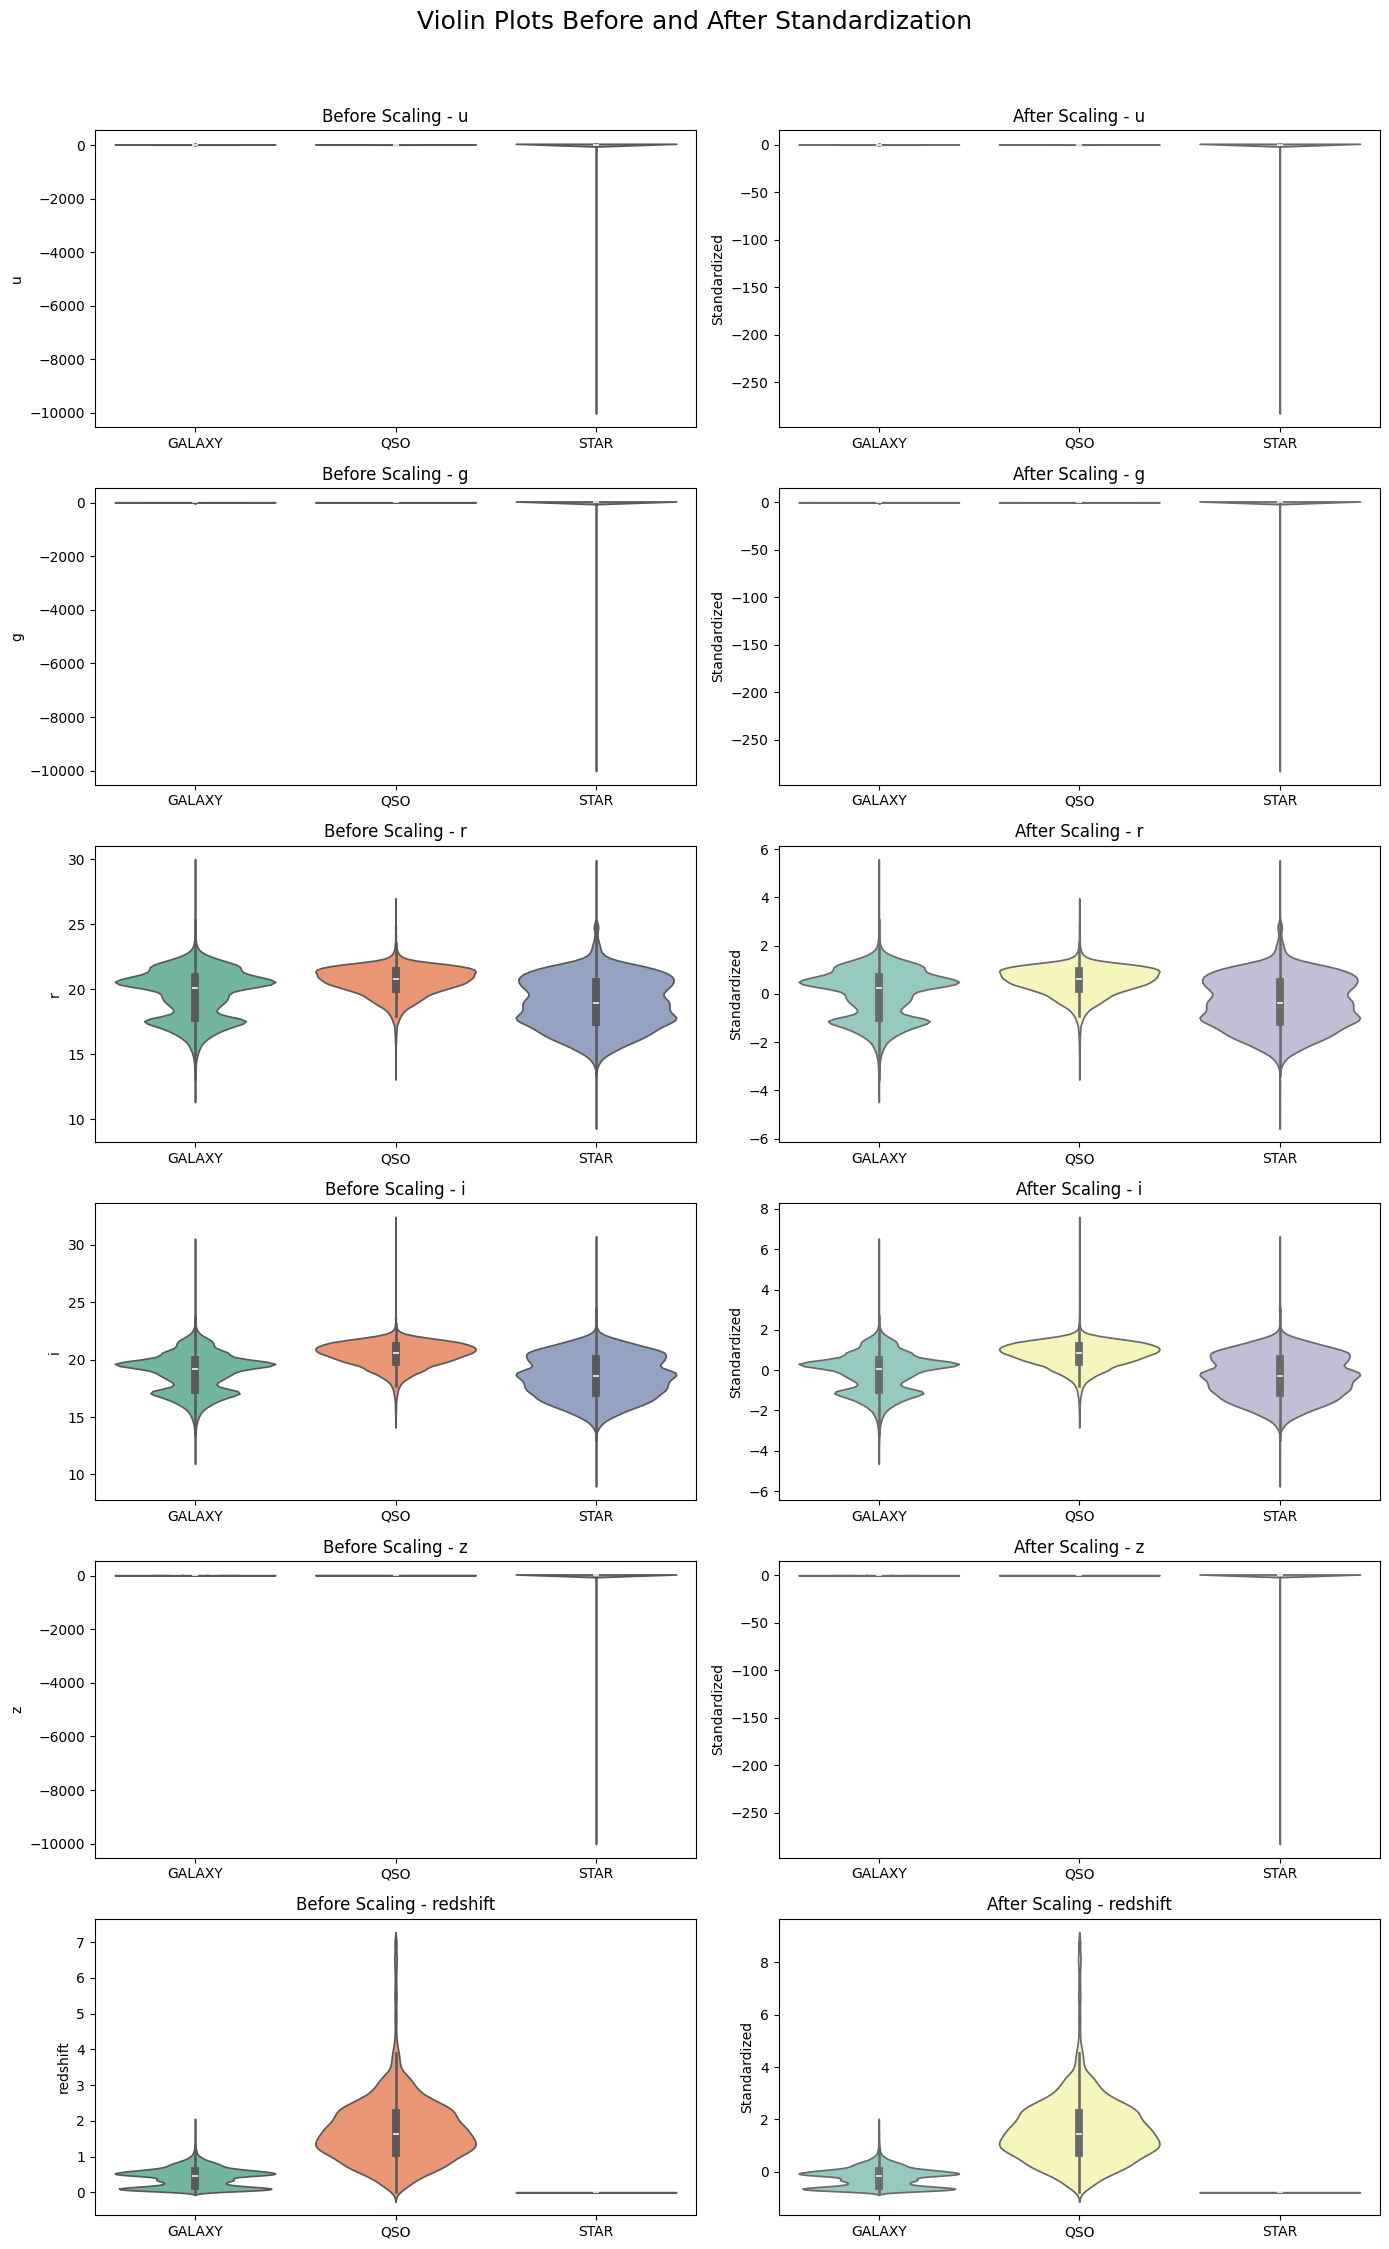

In [10]:
from sklearn.preprocessing import StandardScaler

# Select features and target
features_to_plot = ['u', 'g', 'r', 'i', 'z', 'redshift']
X = train_data[features_to_plot]
y = train_data['class']

# Concatenate for plotting before standardization
before_scaling = X.copy()
before_scaling['class'] = y

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
after_scaling = pd.DataFrame(X_scaled, columns=features_to_plot)
after_scaling['class'] = y.values

# Plot side-by-side violin plots
fig, axes = plt.subplots(nrows=len(features_to_plot), ncols=2, figsize=(14, 22))
fig.suptitle("Violin Plots Before and After Standardization", fontsize=18, y=1.02)

for i, feature in enumerate(features_to_plot):
    sns.violinplot(data=before_scaling, x='class', y=feature, palette='Set2', ax=axes[i, 0], inner='box')
    axes[i, 0].set_title(f"Before Scaling - {feature}")
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel(feature)

    sns.violinplot(data=after_scaling, x='class', y=feature, palette='Set3', ax=axes[i, 1], inner='box')
    axes[i, 1].set_title(f"After Scaling - {feature}")
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel('Standardized')

plt.tight_layout()
plt.show()


* The left column ("Before Scaling") shows the original distributions. Notice the vastly different scales on the y-axes for different features (e.g., 'u', 'g', 'z' have ranges in the thousands, while 'r', 'i', 'redshift' have much smaller ranges). Some distributions ('u', 'g', 'z') appear highly compressed with long tails, suggesting potential outliers or skewed data.

* The right column ("After Scaling") shows the distributions after standardization. Standardization rescales the data, typically to have a mean of 0 and a standard deviation of 1. This brings all features to a comparable scale, centered around zero, which is often beneficial for machine learning algorithms. The shapes of the distributions within each class are preserved, but their scales are now uniform.

## Separate Features and Target

In [25]:
### Separate the features and the target
X_train=df.drop(columns=['class'])
# These are the columns that were kept in your training data before fitting
selected_features = [
    'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'rerun_ID', 'cam_col', 'redshift'
]

## Filter test data using these columns
X = X_train[selected_features]

Y=df['class']

print('Features Shape:',X.shape)
print('Target Shape:',Y.shape)

Features Shape: (80000, 10)
Target Shape: (80000,)


# Pipeline 1 — SVM with PCA (Kernel-based)

We implemented a machine learning pipeline using:

StandardScaler: Standardizes features by removing the mean and scaling to unit variance.
PCA (Principal Component Analysis): Reduces dimensionality while preserving most of the variance in the data. This helps with computational efficiency and noise reduction.
SVM (Support Vector Machine): A kernel-based classifier that performs well in high-dimensional space.

In [26]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

## Pipeline 1: SVM + Scaling + PCA
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('svm', SVC())
])

# Grid of hyperparameters for tuning
svm_param_grid = {
    'pca__n_components' : [5,8,10],
    'svm__C' : [0.1,1,10],
    'svm__gamma' : ['scale','auto'],
    'svm__kernel' : ['rbf']
}

### Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro = make_scorer(f1_score, average='macro')

## Grid search
svm_grid = GridSearchCV(svm_pipeline, svm_param_grid, cv=cv, scoring=f1_macro, n_jobs=-1)
svm_grid.fit(X,Y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=5)),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'pca__n_components': [5, 8, 10],
                         'svm__C': [0.1, 1, 10],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['rbf']},
             scoring=make_scorer(f1_score, response_method='predict', average=macro))

## Result

In [27]:
print("Best SVM parameters:", svm_grid.best_params_)
print("Best F1 Macro Score:", svm_grid.best_score_)

Best SVM parameters: {'pca__n_components': 8, 'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Best F1 Macro Score: 0.9614861917498458


SVMs are particularly effective in nonlinear classification problems. Combining PCA helps reduce overfitting and improves performance, especially on noisy astronomical data. Our best model achieved an F1 Macro Score of 0.961, indicating strong balanced performance across all classes (GALAXY, STAR, QSO).

## Pipeline 2 — Logistic Regression + PCA

In this second pipeline, we used:

StandardScaler
PCA
Logistic Regression: A linear model good for interpretable, fast, and scalable classification.

In [28]:
from sklearn.linear_model import LogisticRegression

# Pipeline: Scaling -> PCA -> Logistic Regression
lr_pipeline=Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('logreg', LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial'))
])

#Hyperparameters for tuning
lr_param_grid ={
    'pca__n_components' : [5, 8, 10],
    'logreg__C' : [0.01, 0.1, 1, 10],
    'logreg__penalty' : ['l1', 'l2'] 
}

#Grid Search with same CV and scorer
lr_grid = GridSearchCV(lr_pipeline, lr_param_grid, cv=cv, scoring=f1_macro, n_jobs=-1)
lr_grid.fit(X,Y)

print("Best Logistic Regression parameters:", lr_grid.best_params_)
print("Best F1 Macro Score:", lr_grid.best_score_)

/Users/sudeepikaliyanapathiranage/Desktop/Dat200/CA4/dat200venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sudeepikaliyanapathiranage/Desktop/Dat200/CA4/dat200venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sudeepikaliyanapathiranage/Desktop/Dat200/CA4/dat200venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warn

Best Logistic Regression parameters: {'logreg__C': 10, 'logreg__penalty': 'l1', 'pca__n_components': 8}
Best F1 Macro Score: 0.9286566652749044


While simpler, Logistic Regression performs surprisingly well when the data is linearly separable in PCA space. It also trains quickly and avoids overfitting. The best configuration achieved an F1 Macro Score of 0.928, which is strong, though slightly lower than the SVM pipeline.

## Evaluate Best Model on 60/40 Train-Test Split
* Use train_test_split() on the original training dataset and plot a confusion matrix.

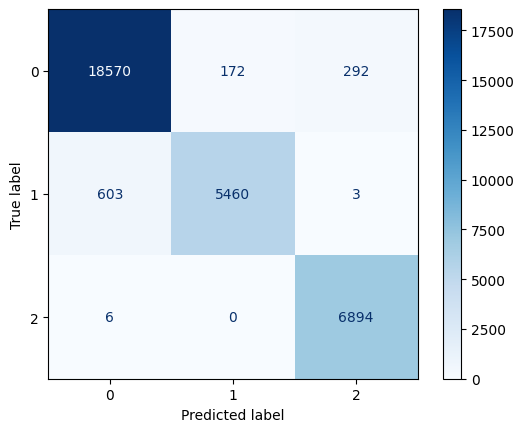

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Split the data (60% train, 40% test)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.4, stratify=Y, random_state=42)

# Refit the best SVM pipeline on 60% training data
best_svm_pipeline = svm_grid.best_estimator_
best_svm_pipeline.fit(X_train, Y_train)

# Predict on 40% test data
y_pred = best_svm_pipeline.predict(X_test)

# Plot Confusion matrix
cm = confusion_matrix(Y_test, y_pred, labels=best_svm_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm_pipeline.classes_)
disp.plot(cmap='Blues')

#### For the test set

In [ ]:

# These are the columns that were kept in your training data before fitting
selected_features = [
    'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'rerun_ID', 'cam_col', 'redshift'
]

## Filter test data using these columns
X_kaggle_test = test_data[selected_features]

## Predict using trained pipeline
kaggle_predictions = best_svm_pipeline.predict(X_kaggle_test)

# Creating Submission DataFrame
submission_df = pd.DataFrame({
    'ID': range(len(kaggle_predictions)),
    'class' : kaggle_predictions
})

submission_df.to_csv('sample_submission.csv', index=False)
print('Submission File saved as sample_submission.csv')

Submission File saved as sample_submission.csv


## Conclusion

Successfully implemented a machine learning pipeline for classifying celestial objects using SDSS data. After exploring data patterns, applying PCA, and tuning classifiers, the SVM model achieved the highest F1-macro score (0.96)

Kaggle submission on behalf of the group: Srivatsav Saravanan
    Best score:  0.962